# Imports

In [44]:
import tensorflow as tf

In [45]:
import pandas as pd

In [46]:
import numpy as np

In [47]:
# import pertinent libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
# [Keras Models]
# import the Keras implementations of VGG16, VGG19, InceptionV3 and Xception models
# the model used here is VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
import tensorflow

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [95]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, "float32"))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float32"))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float32"))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [96]:
f1_metric = F1Score()

In [50]:
import cv2

# Data

## Data Augmentation

In [51]:
import Augmentor
p = Augmentor.Pipeline("data/train")
p.rotate90(probability=0.7)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.3)
p.flip_random(probability = 0.2)
#p.skew(0.5,magnitude=1)
p.random_brightness(0.3,0.75,1.25)
p.process()
p.sample(3000)

Initialised with 600 image(s) found.
Output directory set to data/train\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x230134E03E0>: 100%|██████████| 600/600 [00:03<00:00, 192.82 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x230134FC1A0>: 100%|██████████| 3000/3000 [00:16<00:00, 178.78 Samples/s]                  


## Bilateral Filtering

In [52]:
def Bilateral_filtering(directory):
    for filename in os.listdir(directory):       
        # load the image
        img = cv2.imread(os.path.join(directory, filename))

        # apply bilateral filtering
        filtered_img = cv2.bilateralFilter(img, 6, 75,1475)

        # save the filtered image
        cv2.imwrite(os.path.join(directory,filename), filtered_img)
    

### Train

In [53]:
directory = "data/valid/Positive"
Bilateral_filtering(directory)

In [54]:
directory = "data/valid/Negative"
Bilateral_filtering(directory)

### Val and Test

In [55]:
directory = "data/valid/Positive"
Bilateral_filtering(directory)
directory = "data/valid/Negative"
Bilateral_filtering(directory)

directory = "data/valid/Positive"
Bilateral_filtering(directory)
directory = "data/valid/Negative"
Bilateral_filtering(directory)

## Grayscaling

In [56]:
def Grayscaling(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(filepath, gray_image)

### Train

In [57]:
directory = "data/valid/Positive"
Grayscaling(directory)
directory = "data/valid/Negative"
Grayscaling(directory)

### Val and Test

In [58]:
directory = "data/valid/Positive"
Grayscaling(directory)
directory = "data/valid/Negative"
Grayscaling(directory)

directory = "data/valid/Positive"
Grayscaling(directory)
directory = "data/valid/Negative"
Grayscaling(directory)

# Data Generators

In [59]:
negative_images = os.listdir("data/valid/Negative")
positive_images = os.listdir("data/valid/Positive")

In [60]:
num_classes = 2
image_resize = 224
batch_size_training = 50
batch_size_validation = 50

In [61]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [62]:
train_generator = data_generator.flow_from_directory(
    "data/train/output",
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 7200 images belonging to 2 classes.


In [63]:
validation_generator = data_generator.flow_from_directory(
    'data/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 200 images belonging to 2 classes.


# Model

In [64]:
model = Sequential()
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
model.add(Dense(num_classes, activation='softmax'))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [65]:
model.add(Dense(2, activation = "sigmoid"))

In [66]:
model.layers[0].trainable = False

In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,816 (90.00 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [101]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Compile the model with custom F1 function
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[f1_score]  # Add the custom F1 score function here
)


In [102]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 20

In [105]:
fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1
)


Epoch 1/20


c:\Project\Concrete-Crack-Detection\crack-detection-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - f1_score: 0.7453 - loss: 0.6001 - val_f1_score: 0.7924 - val_loss: 0.4294
Epoch 2/20


C:\Users\jnama\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 763s 5s/step - f1_score: 0.7983 - loss: 0.3823 - val_f1_score: 0.7921 - val_loss: 0.3216
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 853s 6s/step - f1_score: 0.8003 - loss: 0.2840 - val_f1_score: 0.7929 - val_loss: 0.2532
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 680s 5s/step - f1_score: 0.7996 - loss: 0.2206 - val_f1_score: 0.7927 - val_loss: 0.2064
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 427s 3s/step - f1_score: 0.7954 - loss: 0.1784 - val_f1_score: 0.7945 - val_loss: 0.1757
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
144/144 ━━━━

In [119]:
model.evaluate(
    train_generator,
    steps=None,
    callbacks=None
)


144/144 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - f1_score: 1.0000 - loss: 0.0663


[0.06609440594911575, 1.0]

In [120]:
model.save('resnet_model1.h5')

# Model 2

In [121]:
from keras.applications.vgg16 import VGG16


In [122]:
model_vgg = Sequential()
model_vgg.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
model_vgg.add(Dense(num_classes, activation='softmax'))
model_vgg.add(Dense(num_classes, activation ='sigmoid'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [123]:
model_vgg.layers[0].trainable = False

In [124]:
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,720 (56.14 MB)

 Trainable params: 1,032 (4.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [131]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


In [132]:
# Compile the model with the custom F1 score metric
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[F1Score(name='f1_score'), 'accuracy']
)


In [133]:
fit_history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1163s 8s/step - accuracy: 0.7587 - f1_score: 0.0000e+00 - loss: 0.6234 - val_accuracy: 0.9450 - val_f1_score: 0.0000e+00 - val_loss: 0.4969
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


C:\Users\jnama\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1157s 8s/step - accuracy: 0.9718 - f1_score: 0.5502 - loss: 0.4578 - val_accuracy: 0.9500 - val_f1_score: 0.6467 - val_loss: 0.4069
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1052s 7s/step - accuracy: 0.9870 - f1_score: 0.7781 - loss: 0.3603 - val_accuracy: 0.9400 - val_f1_score: 0.9077 - val_loss: 0.3551
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3011s 21s/step - accuracy: 0.9896 - f1_score: 0.9850 - loss: 0.2923 - val_accuracy: 0.9300 - val_f1_score: 0.9175 - val_loss: 0.3211
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1002s 7s/step - accuracy: 0.9926 - f1_score: 0.9902 - loss: 0.2411 - val_accuracy: 0.9150 - val_f1_sc

In [162]:
model_vgg.save('vgg16_model1.h5')

In [163]:
data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
test_generator = data_generator_test.flow_from_directory(
    'data/test',
    target_size=(image_resize, image_resize),
    shuffle=False)


Found 200 images belonging to 2 classes.


In [169]:
# Corrected evaluation call
model_vgg.evaluate(
    test_generator,
    steps=None,  # Optional: Set this if you want to define the number of steps.
    callbacks=None,  # Optional: You can pass callbacks here or set to None.
    verbose=1  # Verbose level (0 = silent, 1 = progress bar, 2 = one line per epoch).
)


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9892 - f1_score: 0.9780 - loss: 0.1285


[0.11229170858860016, 0.9899497628211975, 0.9950000047683716]

## Final Metrics

In [170]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_val = 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))
    return f1_val




In [171]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',recall,precision,f1_score])


### An array of [Loss, Accuracy, Recall, Precision, F1 Score]

In [176]:
# Check the generator and model before evaluation
print(f"Test Generator Length: {len(test_generator)}")
print(f"Model Summary:")
model.summary()  # Directly call model.summary() without formatting

# Re-compile the model to ensure proper setup
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Evaluate the model
try:
    evaluation_results = model.evaluate(
        test_generator,
        steps=len(test_generator),  # Ensure steps are specified correctly
        verbose=1
    )
    print(f"Evaluation Results: {evaluation_results}")
except Exception as e:
    print(f"Error during evaluation: {e}")


Test Generator Length: 7
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,816 (90.00 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0727
Evaluation Results: [0.0668090358376503, 1.0]


### Prediction for cases

In [190]:
directory = "data/predict"
Bilateral_filtering(directory)
Grayscaling(directory)


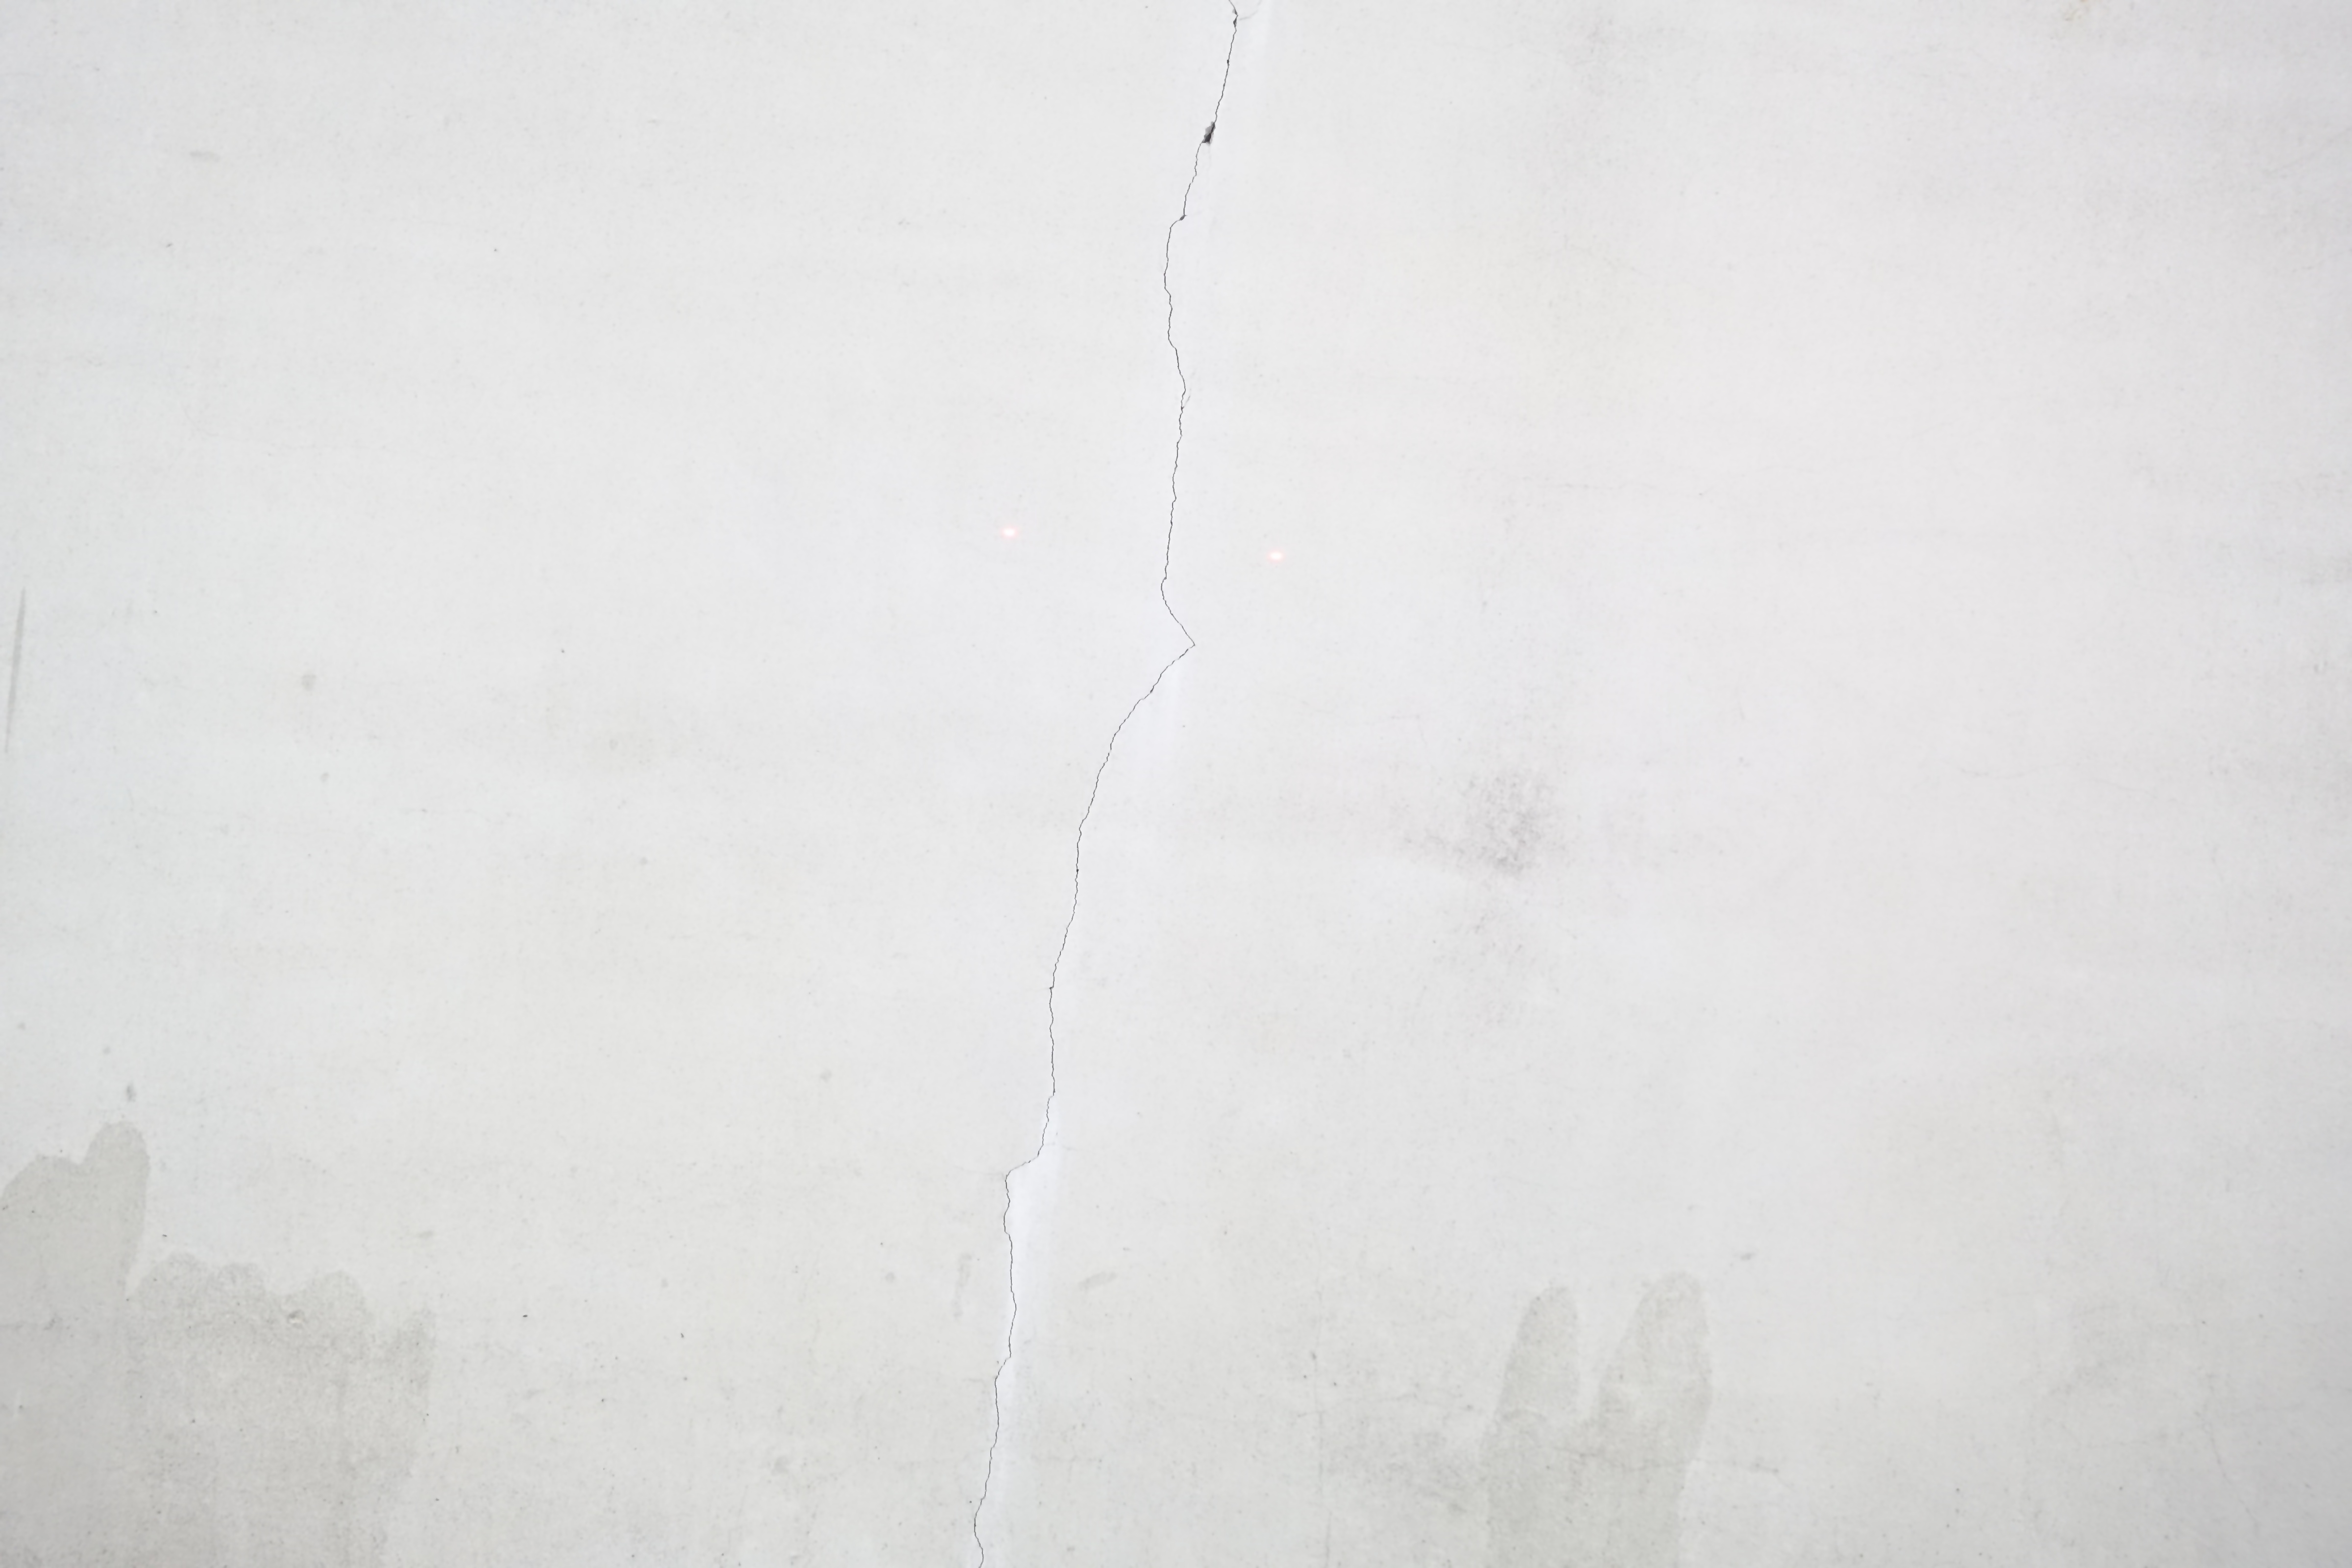

In [191]:
from IPython.display import Image
Image(filename='data/predict/IMG_1129.JPG') 

In [192]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img("data/predict/IMG_1129.JPG", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Print shape to verify
print(f"Image Shape: {x.shape}")


Image Shape: (1, 224, 224, 3)


In [193]:
model = keras.models.load_model('resnet_model1.h5')

# Make a prediction
predictions = model.predict(x)

# Decode the predictions
# Load the class labels
class_labels = [ "Negative","Positive"]

# Get the index of the class with the highest probability
top_class_index = np.argmax(predictions)

# Get the class label
top_class_label = class_labels[top_class_index]
print(top_class_label)







1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Positive
